# Is adopting a healthier lifestyle a long-term social change?

### EPFL CS-401 : Applied Data Analysis Project

### Authors:
* **Alain Birchmeier**
* **Valentin Moullet**
* **Dario Anongba Varela**

### Abstract

The idea of the project is to assess whether the population of western countries is adopting a healthier lifestyle. This project aims to determine if this adoption is a trend or a long-term social change. In either cases, we will try to predict the evolution of this behavior over the upcoming years.

In order to achieve that goal, we will use the Amazon reviews dataset. From those reviews, we can extract information about consumer satisfaction, dates, product categories and the enthousiasm for certain products.

With the emergence of new institutions promoting healthy lifes (like vegan shops or fitness centers), finding insights and patterns in people's behavior could be useful to define in which direction this social change is heading.

### All the data preprocessing is done in the notebook **Data_Preprocessing** for convenience. We will load the data directly from pickles in this notebook. Careful: If you want to get them on your computer, you first have to download the different files [there](http://jmcauley.ucsd.edu/data/amazon/links.html), put them into a folder called 'data/', and then you have to run the code in **Data_Preprocessing**!

## Imports, constants and Utilitary functions

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sb
import gzip
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import datetime
import os
from tqdm import tqdm_notebook as tqdm
rcParams['figure.figsize']=(15, 5)
plt.style.use('ggplot')

In [2]:
DATA_DIR = 'data/'

In [6]:
##### Functions related to the DataFrames directly #####

def get_categories(item):
    for cats in item['categories']:
        for cat in cats:
            yield cat
            
def create_categories_count_df(reviews_df, meta_df):
    merged_df = pd.merge(meta_df[['asin', 'categories']], reviews_df[['asin']], on='asin')
    categories = {}
    for idx, item in merged_df.iterrows():
        for cat in get_categories(item):
            if cat in categories:
                categories[cat] += 1
            else:
                categories[cat] = 1

    count_series = pd.Series(categories, name='count')
    count_series.index.name = 'category'
    count_series.reset_index()
    count_df = count_series.to_frame().sort_values('count', ascending=False)
    
    return count_df

## Raw data

The first task is to collect the Amazon data, organise this data and store it in a ready-to-use data format (pickles). The data is first collected in JSON format, then transformed into Pandas DataFrame, which is finally stored locally as a Pickle.

To achieve this, we do the following:
* Load the reviews data into dataframes
* Load the products metadata into dataframes
* Store the dataframes into Pickle format

Since this analysis is about healthy lifestyles, we will mostly focus on products and reviews from two main categories: **Grocery and Gourmet Food** and **Sports and Outdoors**. As for the distribution, we observed that the amount of data is more important in the **Sports and Outdoors** category than the **Grocery and Gourmet Food**.

In [38]:
# Food
food_reviews_df = pd.read_pickle(DATA_DIR + 'food_reviews_df')
food_meta_df = pd.read_pickle(DATA_DIR + 'food_meta_df')

In [40]:
# Sports
sports_reviews_df = pd.read_pickle(DATA_DIR + 'sports_reviews_df')
sports_meta_df = pd.read_pickle(DATA_DIR + 'sports_meta_df')

In [44]:
print('Number of reviews for Grocery and Gourmet Food:', food_reviews_df.shape[0])
print('Number of products for Grocery and Gourmet Food:', food_meta_df.shape[0])
print('Number of reviews for Sports and Outdoors:', sports_reviews_df.shape[0])
print('Number of products for Sports and Outdoors:', sports_meta_df.shape[0])

Number of reviews for Grocery and Gourmet Food: 1297156
Number of products for Grocery and Gourmet Food: 171760
Number of reviews for Sports and Outdoors: 3268695
Number of products for Sports and Outdoors: 532197


**Products reviews**

In [39]:
food_reviews_df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,datetime
0,A1ZQZ8RJS1XVTX,0657745316,gsxrgirl,"[0, 0]","No sugar, no GMO garbage, no fillers that come...",5.0,Best vanilla I've ever had,1381449600,"10 11, 2013",2013-10-11
1,A31W38VGZAUUM4,0700026444,FIFA Lvr,"[1, 1]","This is my absolute, undisputed favorite tea r...",5.0,Terrific Tea!,1354752000,"12 6, 2012",2012-12-06
2,A3I0AV0UJX5OH0,1403796890,Alicia b,"[0, 0]",I ordered spongbob slippers and I got John Cen...,1.0,grrrrrrr,1385942400,"12 2, 2013",2013-12-02
3,A3QAAOLIXKV383,1403796890,"Danny K. Tilley ""Dan Tilley""","[0, 0]",The cart is fine and works for the purpose for...,3.0,Storage on Wheels Cart,1307836800,"06 12, 2011",2011-06-12
4,AB1A5EGHHVA9M,141278509X,CHelmic,"[1, 1]",This product by Archer Farms is the best drink...,5.0,The best drink mix,1332547200,"03 24, 2012",2012-03-24


**Products metadata**

In [41]:
food_meta_df.head()

,asin,description,title,imUrl,related,salesRank,categories,price,brand
0,0657745316,This is real vanilla extract made with only 3 ...,100 Percent All Natural Vanilla Extract,http://ecx.images-amazon.com/images/I/41gFi5h0...,{'also_viewed': ['B001GE8N4Y']},{'Grocery & Gourmet Food': 374004},[[Grocery & Gourmet Food]],NaN,NaN
1,0700026444,"Silverpot Tea, Pure Darjeeling, is an exquisit...",Pure Darjeeling Tea: Loose Leaf,http://ecx.images-amazon.com/images/I/51hs8sox...,NaN,{'Grocery & Gourmet Food': 620307},[[Grocery & Gourmet Food]],NaN,NaN
2,1403796890,Must have for any WWE Fan\n \n \n \nFeaturing ...,WWE Kids Todler Velvet Slippers featuring John...,http://ecx.images-amazon.com/images/I/518SEST5...,NaN,NaN,[[Grocery & Gourmet Food]],3.99,NaN
3,141278509X,Infused with Vitamins and Electrolytes Good So...,Archer Farms Strawberry Dragonfruit Drink Mix ...,http://ecx.images-amazon.com/images/I/51CFQIis...,{'also_viewed': ['B0051IETTY']},{'Grocery & Gourmet Food': 620322},[[Grocery & Gourmet Food]],NaN,NaN
4,1453060375,MiO Energy is your portable energy source givi...,Mio Energy Liquid Water Enhancer Black Cherry ...,http://ecx.images-amazon.com/images/I/51EUsMcn...,"{'also_viewed': ['B006MSEOJ2', 'B005VOOQLO', '...",{'Grocery & Gourmet Food': 268754},[[Grocery & Gourmet Food]],11.99,Mio


In the reviews, we have different information:
* reviewerID: useful for counting the number of unique users
* asin: useful to link a review to a product
* reviewerName: not useful (will be dropped)
* helpful: not useful (will be dropped)
* reviewText: not useful (will be dropped)
* overall: can be useful to see how people like different products
* summary: not useful (will be dropped)
* unixReviewTime: used for creating a more useful 'datetime' column
* reviewTime: not useful (will be dropped)
* datetime: useful to locate the reviews in time (created from 'unixReviewTime')

In the products metadata, we have other information (about products):
* asin: useful to link a product to a review
* description: useful to determine if a product is healthy or not
* title: useful to determine if a product is healthy or not
* imUrl: not useful (will be dropped)
* related: not useful (will be dropped)
* salesRank: not useful (will be dropped)
* categories: useful to determine if a product is healthy or not
* price: might be useful in the future, we'll keep it (even if quite a lot of missing values)
* brand: too many missing values, not useful enough

## Enrich, filter and transform the data

### Number of reviews per category

First, let's try to see what are the types of products that have been reviewed by people by looking at the different categories in the data from **Grocery and Gourmet Food** and **Sports and Outdoors**.

Note that the **Grocery and Gourmet Food** and **Sports and Outdoors** categories are the root of hierarchy, and all of their related products belong at least to one of those categories. It means that the number of reviews containing the root category will be exactly the number of reviews for the corresponding file.

#### The Grocery and Gourmet Food category

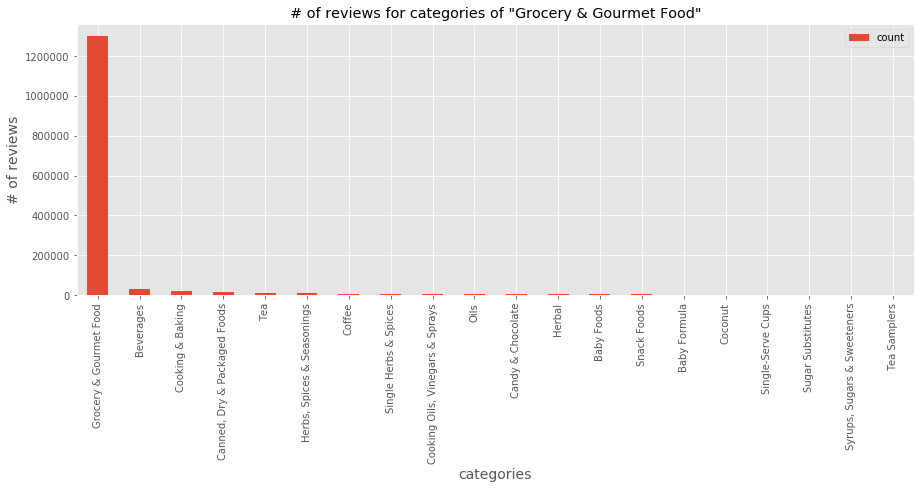

In [108]:
food_cat_count_df = pd.read_pickle(DATA_DIR + 'food_cat_count_df')
food_cat_count_df.head(20).plot(kind='bar', title='# of reviews for categories of "Grocery & Gourmet Food"')
plt.xlabel('categories', fontsize=14)
plt.ylabel('# of reviews', fontsize=14)

We see that the different categories in the 'Grocery & Gourmet Food' file are not directly useful, because:
1. They are not directly telling us if the food is a healthy one or not
2. We see that a lot of reviews are about products that are not in a category (except for the root one 'Grocery & Gourmet Food')
    
In order to get the reviews related to a healthy product in this file, we can try the following: we could read the title (and/or description) of all products in the metadata and find the ones containing some keyword related to a healthy lifestyle (e.g. "organic", "natural", ...). Once we have those products, we can keep only the reviews about those products (using the 'asin' value).

#### The Sports and Outdoors category

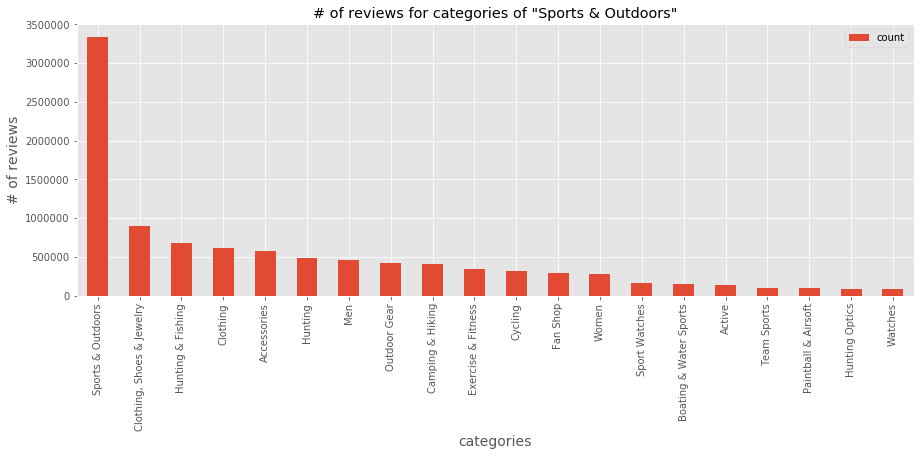

In [110]:
sports_cat_count_df = pd.read_pickle(DATA_DIR + 'sports_cat_count_df')
sports_cat_count_df.head(20).plot(kind='bar', title='# of reviews for categories of "Sports & Outdoors"')
plt.xlabel('categories', fontsize=14)
plt.ylabel('# of reviews', fontsize=14)

Contrary to the previous one, we see that the different products of this file are well distributed among non-root categories, which makes it way easier to use those categories to determine if a product is healthy or not, e.g. 'Exercise & Fitness' or 'Cycling', plus the products seem to be in more "precise" categories (not like in the 'Grocery & Gourmet Food' file). Thus, in order to get all reviews about products related to an healthy lifestyle, we could take all the reviews about a product that is in one of the 'healthy' categories, and we can choose those healthy categories manually.

### Getting reviews about healthy products

#### Restricting the time range
We saw that most categories have data only from the year 2003 until the month of July 2014, so we decided to restrict our data within this time range.

In [6]:
def truncate_date_df(df, col_name='datetime', from_date='2003-01-01', to_date='2014-07-01'):
    return df[(df[col_name] >= from_date) & (df[col_name] < to_date)]

In [85]:
# Healthy food
healthy_food_df = truncate_date_df(pd.read_pickle(DATA_DIR + 'healthy_food_df'))

# Healthy sport
healthy_sports_df = truncate_date_df(pd.read_pickle(DATA_DIR + 'healthy_sports_df'))

Now that we have reviews of healthy products from both files, we can concatenate them and use those as our healthy reviews.

In [86]:
# Merge DFs
merged_healthy_df = pd.concat([healthy_food_df, healthy_sports_df])
print("Number of reviews about healthy products:", merged_healthy_df.shape[0])
merged_healthy_df.head()

Number of reviews about healthy products: 1332644


,asin,title,categories,price,reviewerID,overall,datetime
0,0657745316,100 Percent All Natural Vanilla Extract,[[Grocery & Gourmet Food]],NaN,A1ZQZ8RJS1XVTX,5.0,2013-10-11
1,141278509X,Archer Farms Strawberry Dragonfruit Drink Mix ...,[[Grocery & Gourmet Food]],NaN,AB1A5EGHHVA9M,5.0,2012-03-24
2,1453060375,Mio Energy Liquid Water Enhancer Black Cherry ...,[[Grocery & Gourmet Food]],11.99,A3DTB6RVENLQ9Q,1.0,2013-03-03
3,3295000018,"Kiva Gourmet Smoked, Ghost Chili Pepper Powder...",[[Grocery & Gourmet Food]],14.80,A1Z77SA1BLL25L,4.0,2014-05-09
4,3295000018,"Kiva Gourmet Smoked, Ghost Chili Pepper Powder...",[[Grocery & Gourmet Food]],14.80,A1GDHUUBM6E4EC,5.0,2014-06-16


### Reviews over time

As a naive analysis, we can try to show the number of reviews over time for both root categories and for the merge of them, and deduce from those plots the growth of healthy lifestyle.

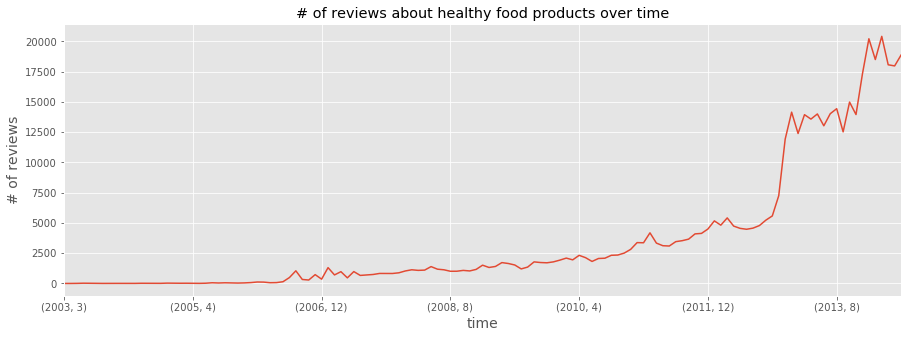

In [112]:
healthy_food_df.groupby([healthy_food_df.datetime.dt.year,
                         healthy_food_df.datetime.dt.month]).agg('count')['asin'].plot(title='# of reviews about healthy food products over time')
plt.xlabel('time', fontsize=14)
plt.ylabel('# of reviews', fontsize=14)

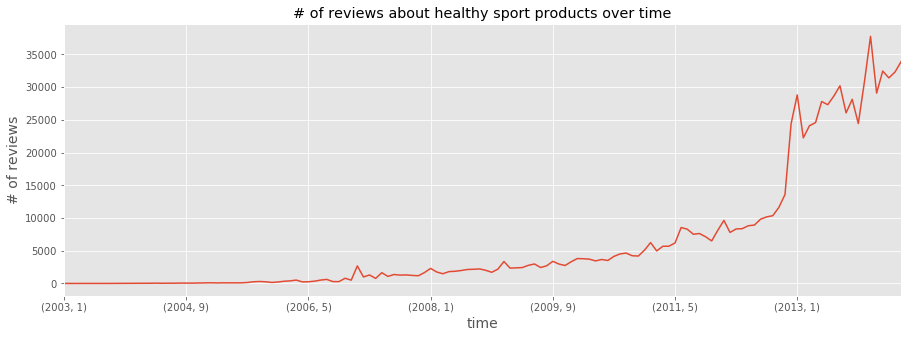

In [114]:
healthy_sports_df.groupby([healthy_sports_df.datetime.dt.year,
                           healthy_sports_df.datetime.dt.month]).agg('count')['asin'].plot(title='# of reviews about healthy sport products over time')
plt.xlabel('time', fontsize=14)
plt.ylabel('# of reviews', fontsize=14)

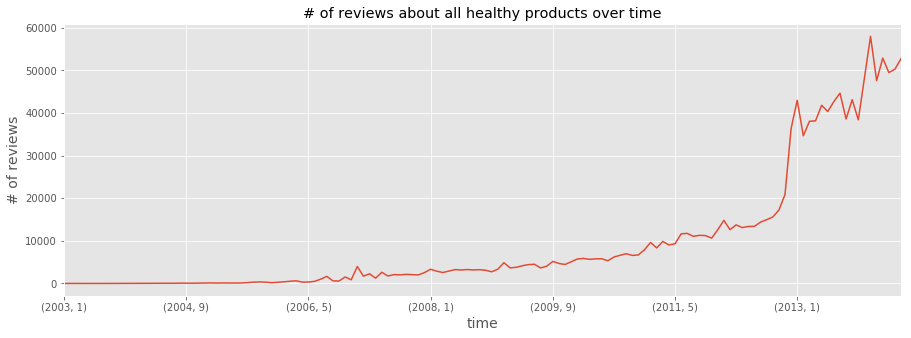

In [115]:
merged_healthy_df.groupby([merged_healthy_df.datetime.dt.year,
                           merged_healthy_df.datetime.dt.month]).agg('count')['asin'].plot(title='# of reviews about all healthy products over time')
plt.xlabel('time', fontsize=14)
plt.ylabel('# of reviews', fontsize=14)

A **very** naive "data scientist" would conclude that healthy products are getting more hype over time. This is obviously not a good analysis, because we have to take into account the growth of Amazon (available products + unique users).

### Amazon's growth over time

Now, we want to see how Amazon has grown over the years. One way to show that is to compute the total number of reviews over time. To do so we will iterate over all file category, and create a dictionary wich contains each month with the number of reviews for the month. We then convert it to a Dataframe and show how the number of reviews growth over the time.

In [3]:
REVIEWS_DATE_FORMAT = "%m %d, %Y"
REVIEWS_GROWTH = 'reviews_count_df'
USER_COUNT = 'users_count_df'

def get_date(item):
    ''' 
    Retrieves the date at what time a given review is done
    '''
    try:
        return datetime.datetime.fromtimestamp(item['unixReviewTime'])
    except KeyError:
        return datetime.datetime.strptime(item['reviewTime'], REVIEWS_DATE_FORMAT)
    
def MonthYearToDate(date_str):
    '''
    Convert a string date of the form "2016-02" to datetime
    '''
    return datetime.datetime.strptime(date_str, "%Y-%m")

def count_review(acc,file_path):
    '''
    Count the number of reviews in a given file and increase the counts in an accumulator
    '''
    skipped = 0
    g = gzip.open(file_path, 'rb')
    for l in g:
        row =  eval(l)
        try:
            date_key = get_date(row).strftime('%Y-%m')
        except (KeyError, ValueError) as e:
            #print('row is : {}'.format(row))      
            skiped += 1
            continue
        if date_key in acc:
            acc[date_key] += 1
        else:
            acc[date_key] = 0
    if skipped :
        print('skipped {} rows because of KeyError (not present) or ValueError (not parsable)'.format(skipped))

In [4]:
def loadCountData(filename, columns, count_func, extra_handling, truncate = False):
    '''
    Load a DataFrame of the count of reviews/users
    '''
    # Check if the file was already computed
    if not os.path.isfile(DATA_DIR + filename):
        print('Computing file...')
        acc =  {}
        # Iterate over the files
        for file in tqdm(os.listdir(DATA_DIR)):
            # Only take reviews files
            if (file.startswith('reviews') and file.endswith('.json.gz')):
                count_func(acc, DATA_DIR + file)
                
        # Convert to DataFrame
        df = pd.DataFrame(list(acc.items()),columns=columns).sort_values('Date')
        # Truncate to take only relevant time frame
        if truncate:
            df = truncate_date_df(df, col_name='Date', from_date='2003-01-01', to_date='2014-07-01')
        # Special operation
        if extra_handling == 'Reviews':
            # Convert Date to datetime and set it to index
            df.Date = df.Date.map(MonthYearToDate)
            df = df.set_index('Date')
        elif extra_handling == 'Users':
            # Count the number of new users by month
            df = df.groupby('Date').count()
            # Create cumulative sum
            df['Total'] = df.NewUsers.cumsum()
        df.to_pickle(DATA_DIR + filename)
    else:
        # Load DataFrame from file
        print('Loading from file...')
        df = pd.read_pickle(DATA_DIR + filename)
        # Truncate if needed
        if truncate:
            df = df.reset_index()
            df = truncate_date_df(df, col_name='Date', from_date='2003-01-01', to_date='2014-07-01')
            df = df.set_index('Date')
    return df


Loading from file...


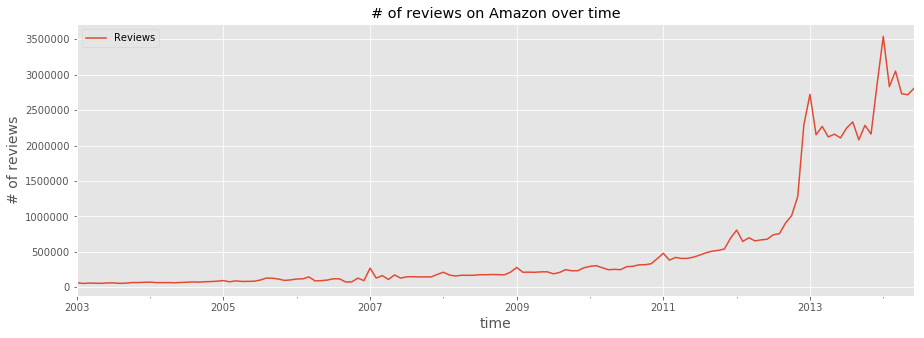

In [7]:
# Load Reviews Growth and show the graph
reviews_growth_df = loadCountData(REVIEWS_GROWTH, ['Date','Reviews'], count_review, 'Reviews', truncate=True)
reviews_growth_df.plot(title='# of reviews on Amazon over time')
plt.xlabel('time', fontsize=14)
plt.ylabel('# of reviews', fontsize=14)

The plot shows an exponential growth in the number of reviews which stabilize somehow in 2013. This may be because people review articles exponentially over the time so to be sure that the number of users grows also exponentially we do the same with the number of users.  
We assume that there is a new user as soon as he does his first review. We iterate again over the all the category files and this time keep track of the month the users make their first review. We then count the number of users for every month. This gives the number of new users over the time. We can take the cumulative sum to know the total number of client growth over the months.

In [8]:
def get_user(item):
    '''
    Retrieves the ReviewID for a given review
    '''
    try:
        reviewerID = item['reviewerID']
    except:
        reviewerID = None
    return reviewerID  

def find_users_first_review(acc,file_path):
    '''
    Find the users first reviews in a given file and update the values in an accumulator
    '''
    skiped = 0
    g = gzip.open(file_path, 'rb')
    for l in g:
        row = eval(l)
        try:
            # Get ReviewerID
            user = get_user(row)
            if user is None:
                # If no ReviewerID go to next
                continue
            # Get review's date
            date_key = get_date(row).strftime('%Y-%m')
            # Update accumulator
            if user in acc and acc[user] > date_key:
                acc[user] = date_key
            else:
                acc[user] = date_key
        except (KeyError, ValueError) as e:
            #print('row is : {}'.format(row))      
            skiped += 1
            continue
    if skiped :
        print('skipped {} rows because of KeyError (not present) or ValueError (not parsable)'.format(skiped))
        

Loading from file...


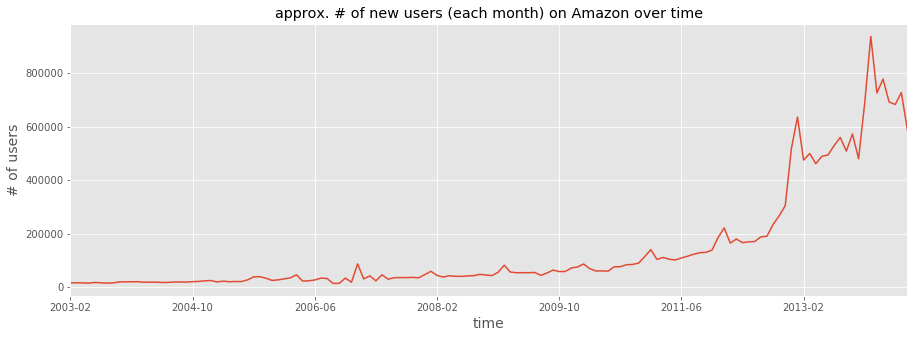

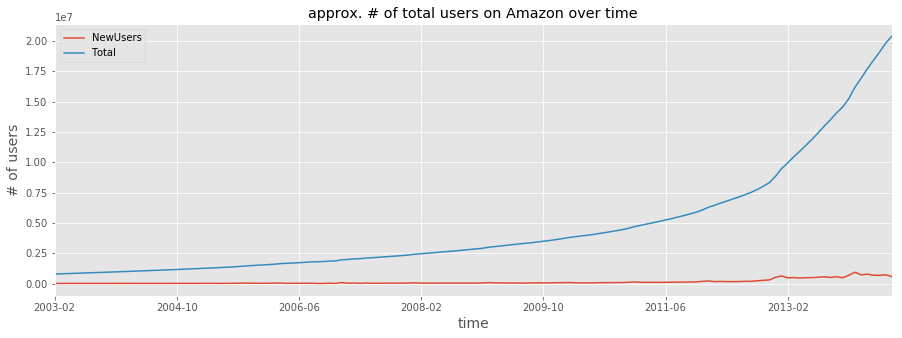

In [15]:
# Load Users Growth and show the graph
users_growth_df = loadCountData(USER_COUNT, ['NewUsers','Date'], find_users_first_review, 'Users', truncate=True)
users_growth_df['NewUsers'].plot(title='approx. # of new users (each month) on Amazon over time')
plt.xlabel('time', fontsize=14)
plt.ylabel('# of users', fontsize=14)
users_growth_df.plot(title='approx. # of total users on Amazon over time')
plt.xlabel('time', fontsize=14)
plt.ylabel('# of users', fontsize=14)

This time the plot shows that the number of new users grows linearly and that the total number of Amazon users grows exponentially.This means that Amazon has grown exponentially over the years. So we must find a different strategy to define if a category of products is more popular than others given the number of reviews.

We explain how we will solve this problem in our plan.

## Plan update and data description

Going through the data, we realised that the inital plan was going to be difficult to implement. It is considerably difficult with only the Amazon data to be able to predict if a behavior is going to last or if it is just a trend. 

Predicting the behavior of society about a healthy lifestyle is impossible with this data because the reviews stop in June 2014. So, instead of trying to predict the behavior in the upcoming years, we will show that it was possible to predict the growing trend of healthy products while analyzing data in 2014.

We decided not to store the data in a MongoDB database because we won't create a web application anymore for this article with interactive data visualization but we will instead write a PDF report in the form of an academic paper. 

We also decided not to use sentiment analysis on the reviews in order to determine the general enthousiasm of people about healthy products but instead we will use the review rating and the number of reviews in many ways, as described in the section below.

### Mathematical details

As previously seen, it is not possible to determine how a category is growing just by looking at the number of reviews or the number of unique users reviewing its products. This is due to the fact that Amazon is (was) generally growing as a whole and the number of reviews and users has grown exponentially.

So an increase in the number of reviews is true for every category.

In order to be able to determine if a category is more popular than others, we decided to visualize the data in many ways and compare categories between each other:

* Showing if **the average rating of a category** is growing or decaying **over time**.
* Showing the **number of new products considered healthy over time**. In order to achieve this, we will assume that a product has been creating the moment the first review for it is written. If more and more healthy products are being created, it will mean that the demand for those type of products is growing.
* Showing **the percentage of unique users reviewing products in comparison with the general percentage of users writing reviews on Amazon**. For example, suppose that the percentage of unique reviewers on Amazon is 5% in general (1000 reviews written by 50 different people), we will compare that number with the percentage of unique reviewers per category (for example, in the category Gourmet and Grocery food, if the number of percentage of unique reviewers is 10%, it would mean that it is 5% superior than the number of unique reviewers in Amazon globally).
* Showing **the percentage of people writing reviews about healthy products compared to the number of people writing reviews for all products per category**. For example, in the Grocery and Gourmet Food category, imagine that the number of healthy products is 10% and the number of reviews about healthy products is 25% (over all products). It would mean that in general, people write more reviews about healthy products than others. We could conclude that healthy products are more hyped this way.
* Showing **price evolution of healthy products** over time. Have prices increased more than the general price increase on Amazon ?
* Showing **price evolution of healthy products compared to all other products** over time. Have prices of healthy products increased more than the general price increase of the corresponding category ?

## Plan of future milestones

### Plan for milestone 3

|Week|Expected task|
|---|---|
|Week 1 and 2| Computing and plotting all the metrics defined in the mathematical details section.
|Week 3| Writing the report while analyzing the results and trying to come up with responses to the initial research questions. 